### 准备主动学习数据集 
- 10%标注 90%未标注 

In [1]:
!python ../tools/prepare_active_dataset.py \
    data/ForestDamages \
    data/ForestDamages/active_learning \
    --train-ratio 0.08 \
    --val-ratio 0.02 \
    --seed 42

合并数据集...
数据根目录: data\ForestDamages
训练集标注文件: data\ForestDamages\annotations\instances_train2024.json
验证集标注文件: data\ForestDamages\annotations\instances_val2024.json
训练集图片目录: data\ForestDamages\train2024
验证集图片目录: data\ForestDamages\val2024


Traceback (most recent call last):
  File "e:\SUAL\SUAL\tools\prepare_active_dataset.py", line 294, in <module>
    prepare_active_dataset(
  File "e:\SUAL\SUAL\tools\prepare_active_dataset.py", line 252, in prepare_active_dataset
    merged_data, src_img_dirs = merge_coco_datasets(data_root)
  File "e:\SUAL\SUAL\tools\prepare_active_dataset.py", line 87, in merge_coco_datasets
    raise FileNotFoundError(f"找不到训练集标注文件: {train_ann}")
FileNotFoundError: 找不到训练集标注文件: data\ForestDamages\annotations\instances_train2024.json


### 准备配置文件

In [1]:
from mmengine import Config
import os.path as osp
import os

# 加载基础配置文件
config_file = 'mmdetection/configs/faster_rcnn/faster-rcnn_x101-32x4d_fpn_2x_coco.py'
cfg = Config.fromfile(config_file)

# ======================
# 基础训练设置
# ======================
cfg.auto_scale_lr.base_batch_size = 8
cfg.max_epochs = 20
cfg.log_level = "INFO"
cfg.interval = 1

# ======================
# 数据路径与类型设置
# ======================
cfg.data_root = 'data/bamberg_coco1024'
cfg.dataset_type = 'BambergTreeDataset'

# ======================
# 检查点与日志设置
# ======================
cfg.default_hooks.checkpoint.interval = 1
cfg.default_hooks.checkpoint.max_keep_ckpts = 3
cfg.default_hooks.checkpoint.save_best = 'auto'
cfg.default_hooks.checkpoint.rule = 'greater'
cfg.default_hooks.logger.interval = 100

# ======================
# 模型设置
# ======================
cfg.model.roi_head.bbox_head.num_classes = 1

# ======================
# 优化器设置
# ======================
cfg.optim_wrapper.type = 'OptimWrapper'
cfg.optim_wrapper.optimizer.type = 'SGD'
cfg.optim_wrapper.optimizer.lr = 0.02
cfg.optim_wrapper.optimizer.weight_decay = 0.0005
cfg.optim_wrapper.optimizer.momentum = 0.9

# ======================
# 数据加载器设置
# ======================

# 训练数据加载器
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.ann_file = "annotations/instances_tree_train2023_cleaned_jpg.json"
cfg.train_dataloader.dataset.data_prefix = dict(img='train2023/')
cfg.train_dataloader.num_workers = 8
cfg.train_dataloader.batch_size = 8

# 验证数据加载器
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.ann_file = "annotations/instances_tree_eval2023_cleaned_jpg.json"
cfg.val_dataloader.dataset.data_prefix = dict(img='val2023/')
cfg.val_dataloader.num_workers = 8
cfg.val_dataloader.batch_size = 1

# 测试数据加载器
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.ann_file = "annotations/instances_tree_eval2023_cleaned_jpg.json"
cfg.test_dataloader.num_workers = 8
cfg.test_dataloader.batch_size = 1

# ======================
# 评估器设置
# ======================
cfg.test_evaluator.ann_file = osp.join(cfg.data_root, 'annotations/instances_tree_eval2023_cleaned_jpg.json')
cfg.val_evaluator.ann_file = osp.join(cfg.data_root, 'annotations/instances_tree_eval2023_cleaned_jpg.json')
cfg.test_dataloader.dataset.data_prefix = dict(img='val2023/')
# ======================
# 训练配置
# ======================
cfg.train_cfg.max_epochs = cfg.max_epochs
cfg.train_cfg.val_interval = 1  # 根据需要自定义验证间隔

# ======================
# 工作目录设置
# ======================
cfg.work_dir = './work_dirs/faster_rcnn_bamberg1024'

# ======================
# 保存配置文件
# ======================
cfg.dump('my_configs/faster_rcnn_bamberg1024.py')

### 监督训练

In [ ]:
!python tools/train.py my_configs\faster_rcnn_bamberg1024.py --work-dir work_dirs\faster_rcnn_bamberg1024

### 主动学习训练

In [1]:
from mmengine import Config
import os.path as osp
import os


cfg.data_root = "data/bamberg_coco1024/active_learning"
# 加载基础配置文件
config_file = 'my_configs/faster_rcnn_bamberg1024.py'
cfg = Config.fromfile(config_file)
# 添加主动学习配置
cfg.active_learning = dict(
    data_root='data/bamberg_coco1024/active_learning',
    inference_options=dict(
        max_det=300,
        nms_thr=0.4,
        save_results=True,
        score_thr=0.45,
        uncertainty_methods=[
            'entropy',
            'normalized_entropy',
            'max_sor',
            'avg_sor',
            'sum_sor',
        ]),
    max_iterations=10,
    sample_selection=dict(
        num_samples=200, strategy='uncertainty', uncertainty_method='avg_sor'))
cfg.metainfo = dict(
    classes=('tree', ), palette=[
        (
            220,
            20,
            60,
        ),
    ])
cfg.max_epochs = 2
cfg.train_cfg.val_interval = 1
cfg.train_cfg.max_epochs = cfg.max_epochs
cfg.train_cfg.val_interval = 1  # 根据需要自定义验证间隔
cfg.dataset_type = 'ActiveCocoDataset'
cfg.log_level ="ERROR"
cfg.test_dataloader.dataset.ann_file = 'annotations/instances_tree_eval2023_cleaned_jpg.json'
cfg.test_dataloader.dataset.data_prefix = dict(img='val2023/')
# cfg.test_dataloader.dataset.type = 'ActiveCocoDataset'## 注意
cfg.test_evaluator.ann_file = 'data/bamberg_coco1024/instances_tree_eval2023_cleaned_jpg.json'
cfg.train_cfg.val_interval = 1
cfg.train_cfg.max_epochs = cfg.max_epochs
cfg.train_dataloader.dataset.ann_file = f'{cfg.data_root}/active_learning/annotations/instances_labeled_train.json'
cfg.train_dataloader.dataset.data_prefix = dict(img=f'{cfg.data_root}/images_labeled_train/')
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.type = 'ActiveCocoDataset'



cfg.val_dataloader.dataset.ann_file = f'{cfg.data_root}/active_learning/annotations/instances_labeled_val.json'
cfg.val_dataloader.dataset.data_prefix = dict(img=f'{cfg.data_root}/active_learning/images_labeled_val/')
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.type = 'ActiveCocoDataset'
cfg.val_evaluator.ann_file = f"{cfg.data_root}/annotations/instances_labeled_val.json"

cfg.train_dataloader.dataset.metainfo = cfg.metainfo
cfg.val_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

cfg.work_dir = './work_dirs/faster_rcnn_bamberg1024_al'
print(cfg.pretty_text)


cfg.dump('my_configs/faster_rcnn_bamberg1024_al.py')

active_learning = dict(
    data_root='data/bamberg_coco1024/active_learning',
    inference_options=dict(
        max_det=300,
        nms_thr=0.4,
        save_results=True,
        score_thr=0.45,
        uncertainty_methods=[
            'entropy',
            'normalized_entropy',
            'max_sor',
            'avg_sor',
            'sum_sor',
        ]),
    max_iterations=10,
    sample_selection=dict(
        num_samples=200, strategy='uncertainty', uncertainty_method='avg_sor'))
auto_scale_lr = dict(base_batch_size=8, enable=False)
backend_args = None
data_root = 'data/bamberg_coco1024'
dataset_type = 'ActiveCocoDataset'
default_hooks = dict(
    checkpoint=dict(
        interval=1,
        max_keep_ckpts=3,
        rule='greater',
        save_best='auto',
        type='CheckpointHook'),
    logger=dict(interval=100, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHo

In [11]:
import os
os.environ['PYTHONIOENCODING'] = 'utf-8'

In [12]:
!python tools/al_train.py my_configs/faster_rcnn_bamberg1024_al.py --work-dir work_dirs/faster_rcnn_bamberg1024_al

数据根目录: data/bamberg_coco1024
训练集图片目录: data/bamberg_coco1024/active_learning/images_labeled_train/
训练集标注文件: data/bamberg_coco1024/avtive_learning/annotations/instances_labeled_train.json
警告: 标注文件不存在: data/bamberg_coco1024/avtive_learning/annotations/instances_labeled_train.json

开始第 1/10 轮主动学习...


Traceback (most recent call last):
  File "e:\SUAL\tools\al_train.py", line 228, in <module>
    main()
  File "e:\SUAL\tools\al_train.py", line 176, in main
    runner = Runner.from_cfg(cfg)
  File "e:\sual\mmengine\mmengine\runner\runner.py", line 462, in from_cfg
    runner = cls(
  File "e:\sual\mmengine\mmengine\runner\runner.py", line 403, in __init__
    self._log_env(env_cfg)
  File "e:\sual\mmengine\mmengine\runner\runner.py", line 2368, in _log_env
    env = collect_env()
  File "e:\sual\mmengine\mmengine\utils\dl_utils\collect_env.py", line 141, in collect_env
    env_info['MSVC'] = cc.decode(encoding).partition('\n')[0].strip()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 0: invalid continuation byte


### 分析teacher模型输出

In [2]:
!python tools/analyze_al_result.py --work-dir work_dir/al

已保存 round_0 的分数分布直方图
警告: work_dir\al\round_0_scores_distribution.png\teacher_outputs 不存在
已保存 round_1 的分数分布直方图
警告: work_dir\al\round_1_scores_distribution.png\teacher_outputs 不存在
已保存 round_2 的分数分布直方图
警告: work_dir\al\round_2_scores_distribution.png\teacher_outputs 不存在
已保存 round_3 的分数分布直方图
警告: work_dir\al\round_3_scores_distribution.png\teacher_outputs 不存在
已保存 round_4 的分数分布直方图
警告: work_dir\al\round_4_scores_distribution.png\teacher_outputs 不存在


### 选出阈值以上的样本，检核CDE错误

In [5]:
!python tools/select_results.py \
    --work-dir work_dir/al \
    --threshold 0.7 \
    --output-dir work_dir/al/select0.7

警告: work_dir\al\round_0_scores_distribution.png\teacher_outputs 不存在
警告: work_dir\al\round_1_scores_distribution.png\teacher_outputs 不存在
警告: work_dir\al\round_2_scores_distribution.png\teacher_outputs 不存在
警告: work_dir\al\round_3_scores_distribution.png\teacher_outputs 不存在
已选择: DJI_0475_Cropped_30_result.json 和 DJI_0475_Cropped_30_vis.jpg
警告: work_dir\al\round_4_scores_distribution.png\teacher_outputs 不存在


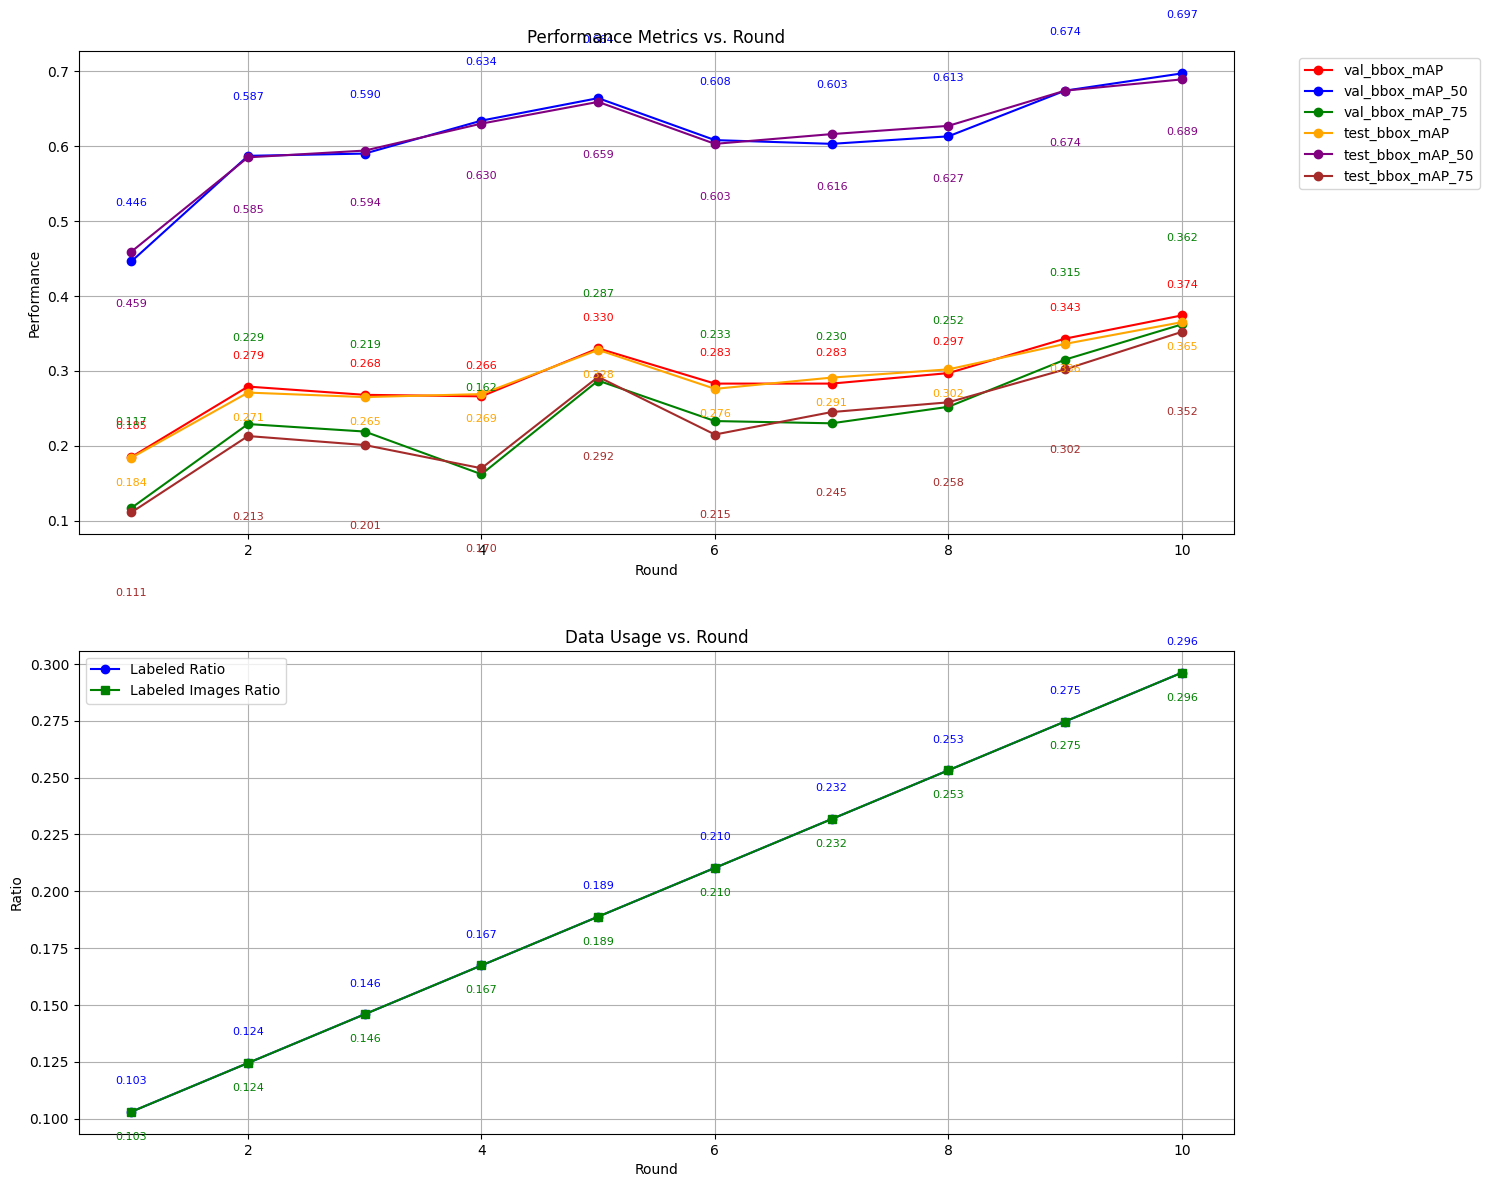

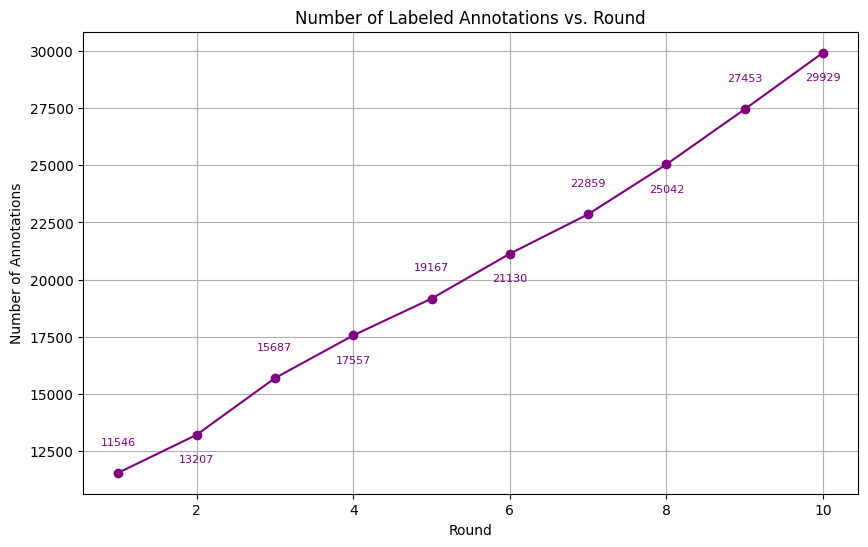

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('work_dirs/faster_rcnn_bamberg1024_al8/performance_history.csv')

# 设置图表风格
plt.style.use('default')
plt.figure(figsize=(15, 12))  # 增加图表高度

# 1. 性能指标随轮次的变化
plt.subplot(2, 1, 1)
metrics = ['val_bbox_mAP', 'val_bbox_mAP_50', 'val_bbox_mAP_75',
           'test_bbox_mAP', 'test_bbox_mAP_50', 'test_bbox_mAP_75']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# 为不同指标设置不同的垂直偏移
offsets = [20, 40, 60, -20, -40, -60]

for metric, color, offset in zip(metrics, colors, offsets):
    line = plt.plot(df['round'], df[metric], marker='o', label=metric, color=color)
    # 添加数据标注
    for x, y in zip(df['round'], df[metric]):
        plt.annotate(f'{y:.3f}', 
                    (x, y), 
                    textcoords="offset points", 
                    xytext=(0, offset),  # 使用不同的垂直偏移
                    ha='center',
                    fontsize=8,
                    color=color)  # 标注颜色与线条对应

plt.title('Performance Metrics vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Performance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 2. 标注数据量随轮次的变化
plt.subplot(2, 1, 2)
# 绘制标注比例
labeled_ratio_line = plt.plot(df['round'], df['labeled_ratio'], 
                             marker='o', label='Labeled Ratio', color='blue')
for x, y in zip(df['round'], df['labeled_ratio']):
    plt.annotate(f'{y:.3f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, 20),  # 向上偏移
                ha='center',
                fontsize=8,
                color='blue')

# 绘制图像比例
images_ratio = df['labeled_images']/df['total_images']
images_line = plt.plot(df['round'], images_ratio, 
                      marker='s', label='Labeled Images Ratio', color='green')
for x, y in zip(df['round'], images_ratio):
    plt.annotate(f'{y:.3f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, -20),  # 向下偏移
                ha='center',
                fontsize=8,
                color='green')

plt.title('Data Usage vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)

# 调整布局，留出更多空间给标注
plt.tight_layout(h_pad=2)  # 增加子图之间的垂直间距
plt.show()

# 额外绘制标注数量的变化
plt.figure(figsize=(10, 6))
line = plt.plot(df['round'], df['labeled_annotations'], marker='o', color='purple')
# 添加标注数量的数据标注，交替上下位置
for i, (x, y) in enumerate(zip(df['round'], df['labeled_annotations'])):
    offset = 20 if i % 2 == 0 else -20  # 交替上下偏移
    plt.annotate(f'{y}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, offset),
                ha='center',
                fontsize=8,
                color='purple')

plt.title('Number of Labeled Annotations vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Number of Annotations')
plt.grid(True)
plt.show()

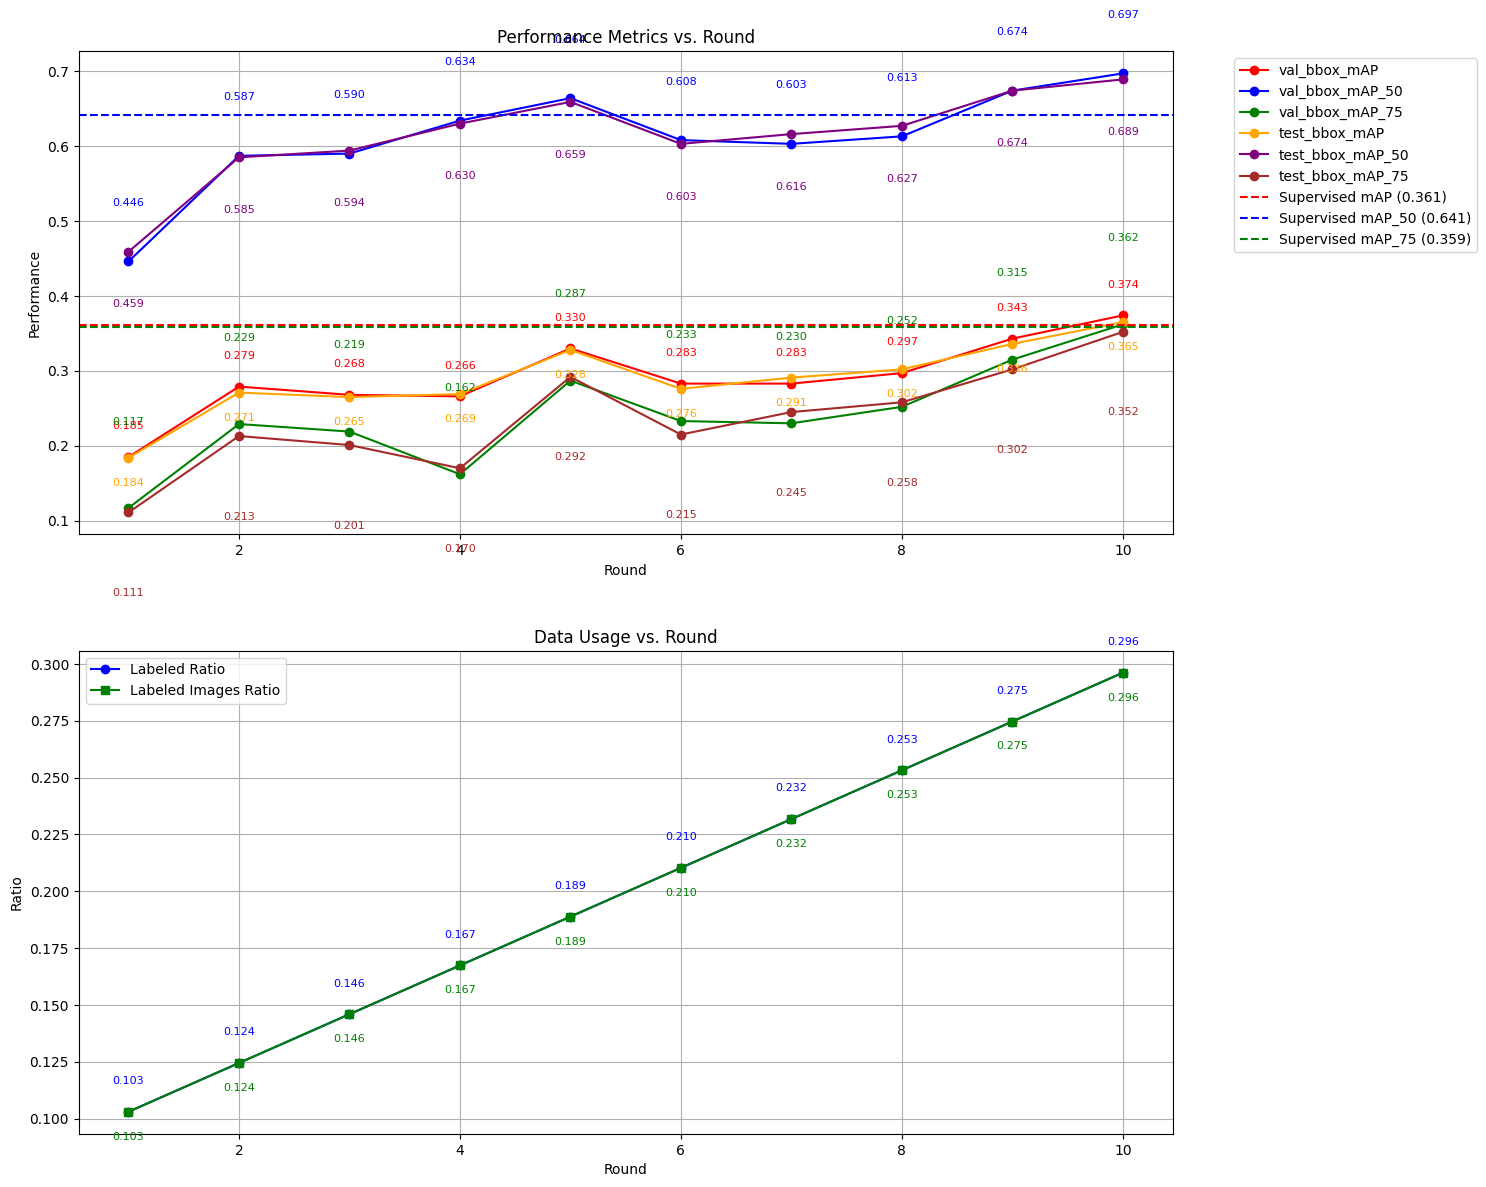

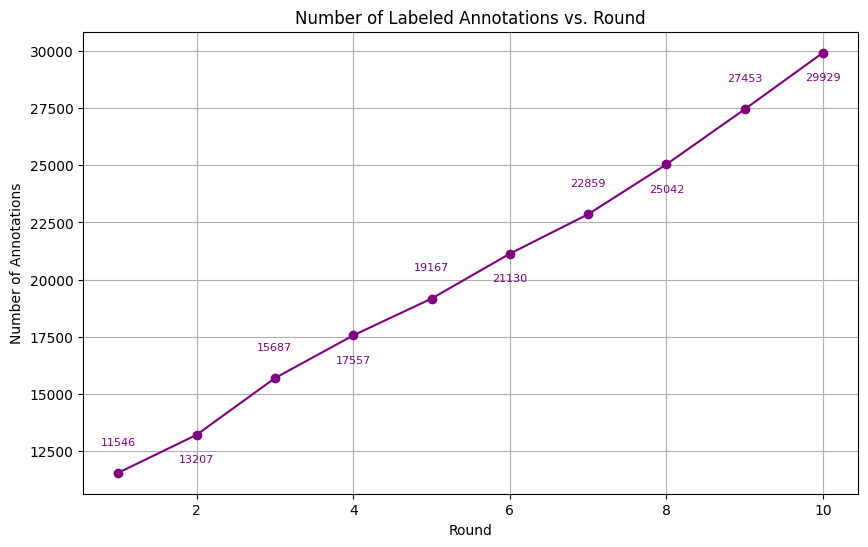

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('work_dirs/faster_rcnn_bamberg1024_al8/performance_history.csv')

# 监督学习的性能指标
supervised_metrics = {
    'bbox_mAP': 0.3610,
    'bbox_mAP_50': 0.6410,
    'bbox_mAP_75': 0.3590
}

# 设置图表风格
plt.style.use('default')
plt.figure(figsize=(15, 12))

# 1. 性能指标随轮次的变化
plt.subplot(2, 1, 1)
metrics = ['val_bbox_mAP', 'val_bbox_mAP_50', 'val_bbox_mAP_75',
           'test_bbox_mAP', 'test_bbox_mAP_50', 'test_bbox_mAP_75']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
offsets = [20, 40, 60, -20, -40, -60]

# 绘制主动学习的性能曲线
for metric, color, offset in zip(metrics, colors, offsets):
    line = plt.plot(df['round'], df[metric], marker='o', label=metric, color=color)
    # 添加数据标注
    for x, y in zip(df['round'], df[metric]):
        plt.annotate(f'{y:.3f}', 
                    (x, y), 
                    textcoords="offset points", 
                    xytext=(0, offset),
                    ha='center',
                    fontsize=8,
                    color=color)

# 添加监督学习的基准线
plt.axhline(y=supervised_metrics['bbox_mAP'], color='red', linestyle='--', 
            label='Supervised mAP (0.361)')
plt.axhline(y=supervised_metrics['bbox_mAP_50'], color='blue', linestyle='--', 
            label='Supervised mAP_50 (0.641)')
plt.axhline(y=supervised_metrics['bbox_mAP_75'], color='green', linestyle='--', 
            label='Supervised mAP_75 (0.359)')

plt.title('Performance Metrics vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Performance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 2. 标注数据量随轮次的变化
plt.subplot(2, 1, 2)
# 绘制标注比例
labeled_ratio_line = plt.plot(df['round'], df['labeled_ratio'], 
                             marker='o', label='Labeled Ratio', color='blue')
for x, y in zip(df['round'], df['labeled_ratio']):
    plt.annotate(f'{y:.3f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, 20),
                ha='center',
                fontsize=8,
                color='blue')

# 绘制图像比例
images_ratio = df['labeled_images']/df['total_images']
images_line = plt.plot(df['round'], images_ratio, 
                      marker='s', label='Labeled Images Ratio', color='green')
for x, y in zip(df['round'], images_ratio):
    plt.annotate(f'{y:.3f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, -20),
                ha='center',
                fontsize=8,
                color='green')

plt.title('Data Usage vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)

# 调整布局
plt.tight_layout(h_pad=2)
plt.show()

# 额外绘制标注数量的变化
plt.figure(figsize=(10, 6))
line = plt.plot(df['round'], df['labeled_annotations'], marker='o', color='purple')
# 添加标注数量的数据标注
for i, (x, y) in enumerate(zip(df['round'], df['labeled_annotations'])):
    offset = 20 if i % 2 == 0 else -20
    plt.annotate(f'{y}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, offset),
                ha='center',
                fontsize=8,
                color='purple')

plt.title('Number of Labeled Annotations vs. Round', fontsize=12)
plt.xlabel('Round')
plt.ylabel('Number of Annotations')
plt.grid(True)
plt.show()

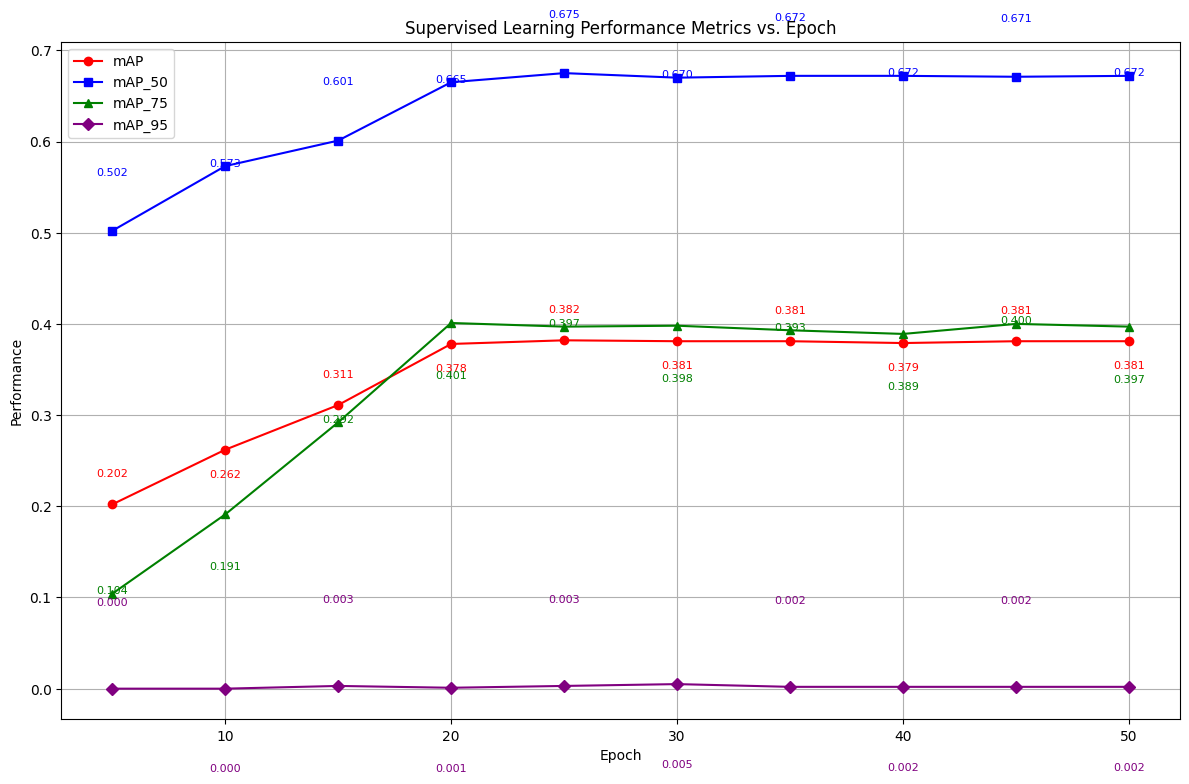

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# 从JSON文件中提取性能指标
performance_data = []
with open('work_dirs\\faster_rcnn_foresdamage\\20241227_232520\\vis_data\\20241227_232520.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'coco/bbox_mAP' in data:
            performance_data.append({
                'step': data['step'],
                'mAP': data['coco/bbox_mAP'],
                'mAP_50': data['coco/bbox_mAP_50'],
                'mAP_75': data['coco/bbox_mAP_75'],
                'mAP_95': data['coco/bbox_mAP_95']
            })

# 转换为DataFrame
df_sup = pd.DataFrame(performance_data)

# 创建图表
plt.figure(figsize=(12, 8))

# 绘制性能曲线
plt.plot(df_sup['step'], df_sup['mAP'], marker='o', label='mAP', color='red')
plt.plot(df_sup['step'], df_sup['mAP_50'], marker='s', label='mAP_50', color='blue')
plt.plot(df_sup['step'], df_sup['mAP_75'], marker='^', label='mAP_75', color='green')
plt.plot(df_sup['step'], df_sup['mAP_95'], marker='D', label='mAP_95', color='purple')  # 绘制 mAP_95 曲线，使用菱形标记，颜色为紫色

# 添加数据标注（交错显示以避免重叠）
for i, (step, mAP, mAP_50, mAP_75, mAP_95) in enumerate(zip(df_sup['step'], df_sup['mAP'], df_sup['mAP_50'], df_sup['mAP_75'], df_sup['mAP_95'])):
    offset = 20 if i % 2 == 0 else -20
    plt.annotate(f'{mAP:.3f}', (step, mAP), textcoords="offset points", 
                xytext=(0, offset), ha='center', color='red', fontsize=8)
    plt.annotate(f'{mAP_50:.3f}', (step, mAP_50), textcoords="offset points", 
                xytext=(0, offset+20), ha='center', color='blue', fontsize=8)
    plt.annotate(f'{mAP_75:.3f}', (step, mAP_75), textcoords="offset points", 
                xytext=(0, offset-20), ha='center', color='green', fontsize=8)
    plt.annotate(f'{mAP_95:.3f}', (step, mAP_95), textcoords="offset points",  # 添加 mAP_95 的数据标注
                xytext=(0, offset+40 if i % 2 == 0 else offset-40), ha='center', color='purple', fontsize=8)

# 设置图表属性
plt.title('Supervised Learning Performance Metrics vs. Epoch', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()

# 调整布局
plt.tight_layout()
plt.show()

### faster_rcnn

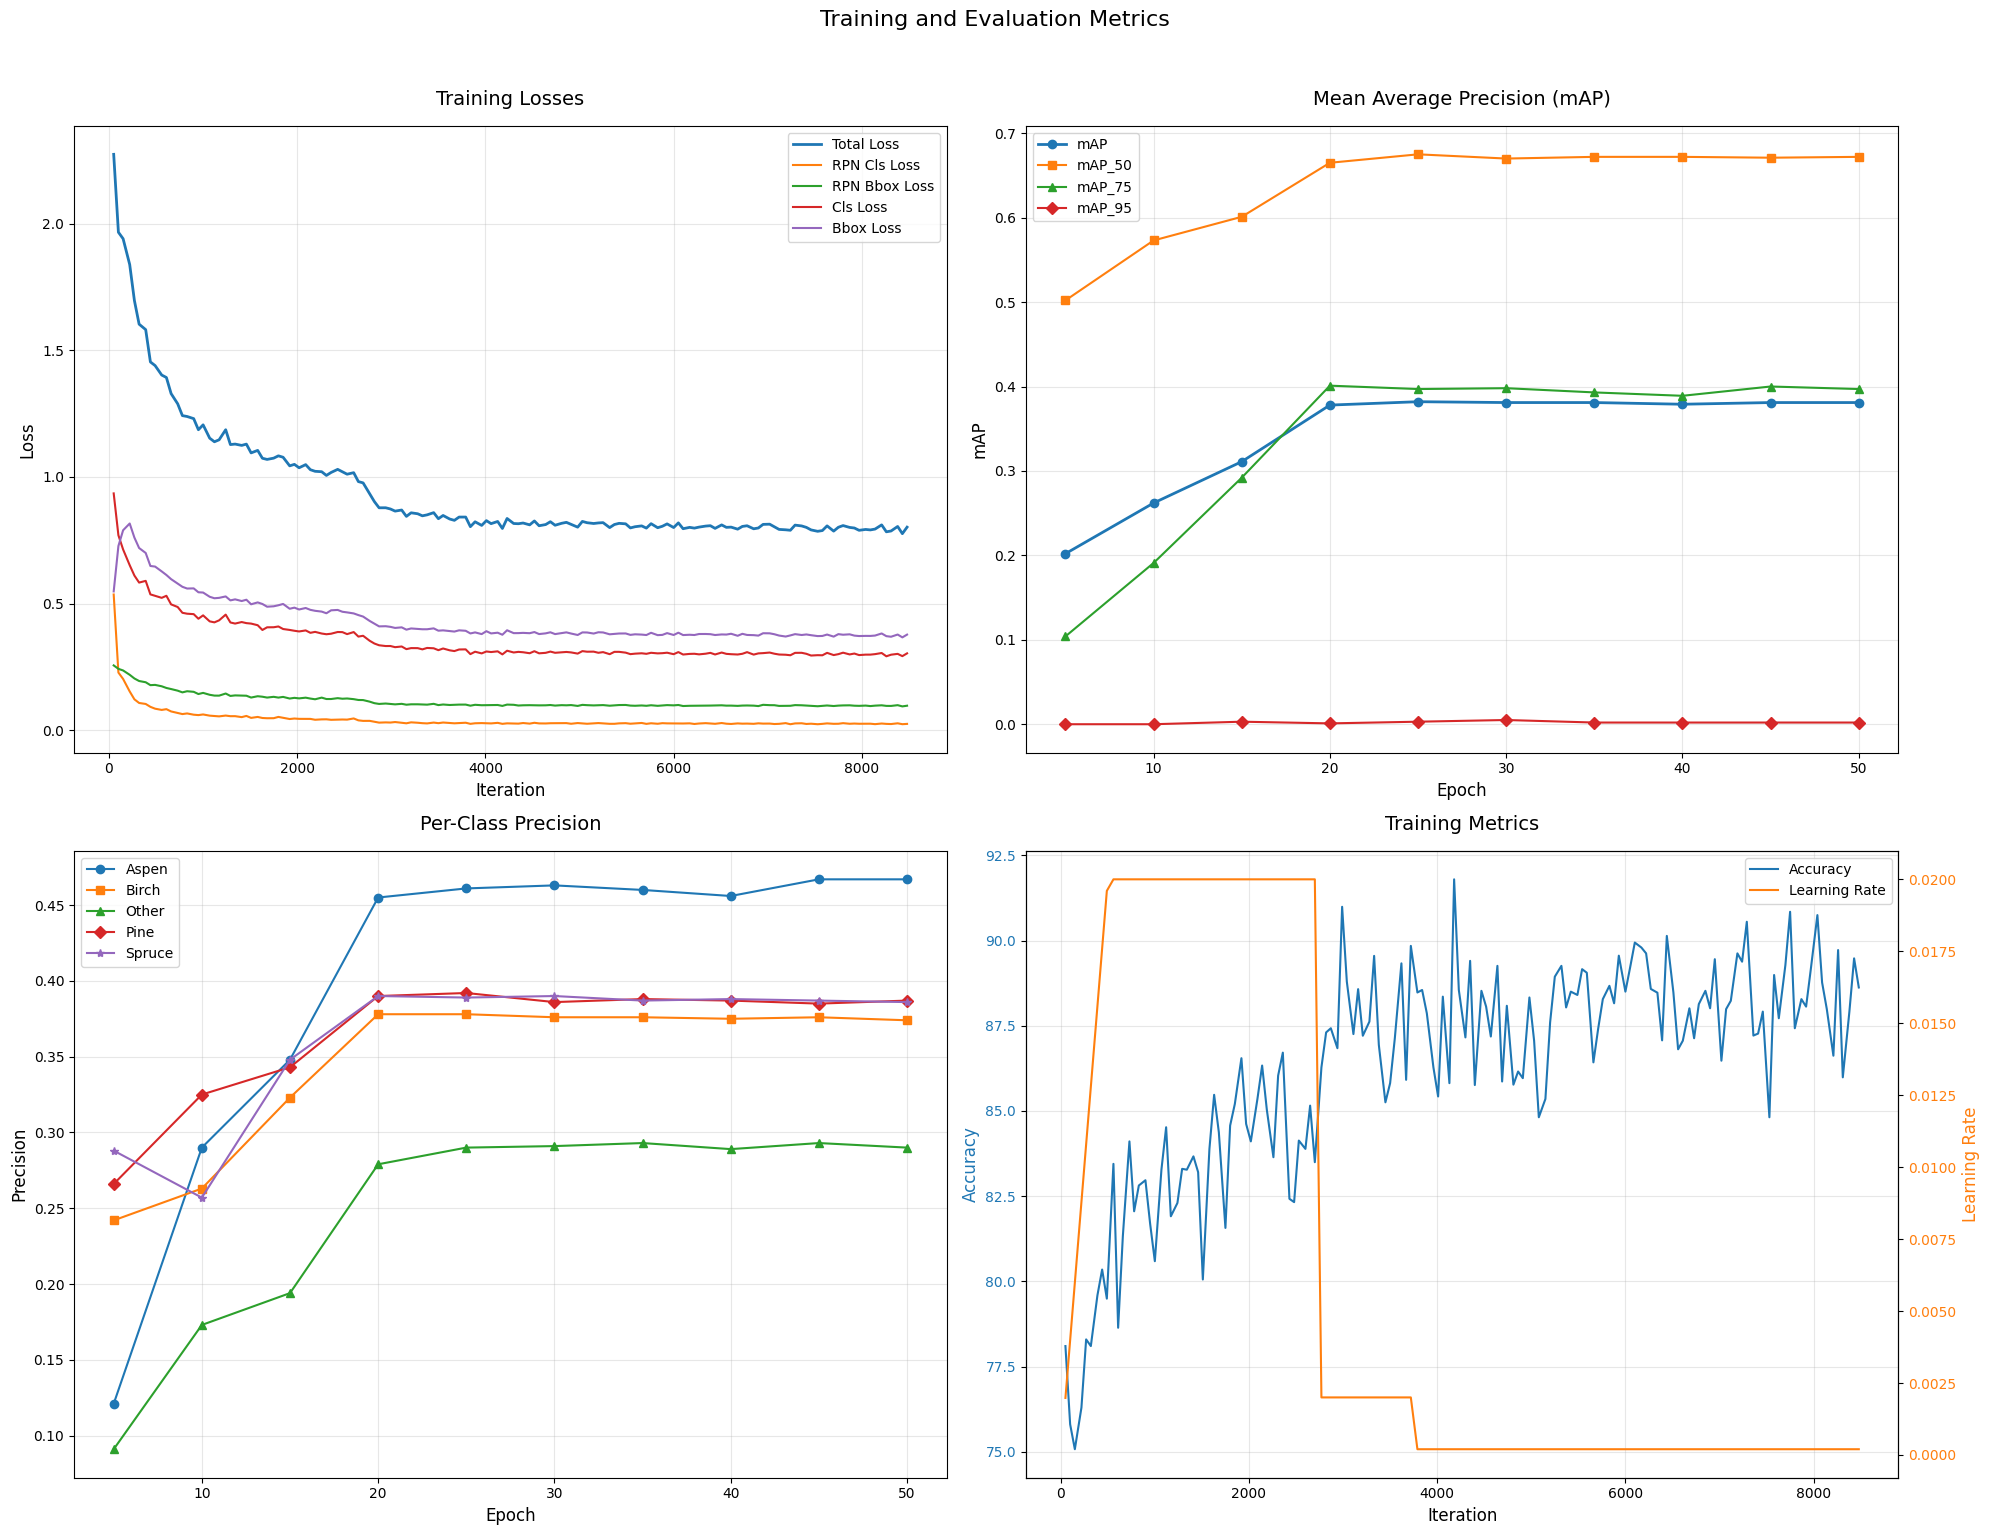

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取数据
training_data = []
performance_data = []

with open('work_dirs\\faster_rcnn_foresdamage\\20241227_232520\\vis_data\\20241227_232520.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'coco/bbox_mAP' in data:
            # 性能指标数据
            performance_data.append({
                'step': data['step'],
                'mAP': data['coco/bbox_mAP'],
                'mAP_50': data['coco/bbox_mAP_50'],
                'mAP_75': data['coco/bbox_mAP_75'],
                'mAP_95': data['coco/bbox_mAP_95'],
                'mAP_s': data['coco/bbox_mAP_s'],
                'mAP_m': data['coco/bbox_mAP_m'],
                'mAP_l': data['coco/bbox_mAP_l'],
                'Aspen': data['coco/Aspen_precision'],
                'Birch': data['coco/Birch_precision'],
                'Other': data['coco/Other_precision'],
                'Pine': data['coco/Pine_precision'],
                'Spruce': data['coco/Spruce_precision']
            })
        else:
            # 训练过程数据
            training_data.append({
                'epoch': data['epoch'],
                'iter': data['iter'],
                'loss': data['loss'],
                'loss_rpn_cls': data['loss_rpn_cls'],
                'loss_rpn_bbox': data['loss_rpn_bbox'],
                'loss_cls': data['loss_cls'],
                'loss_bbox': data['loss_bbox'],
                'acc': data['acc'],
                'lr': data['lr'],
                'data_time': data['data_time'],
                'time': data['time']
            })

# 转换为DataFrame
df_train = pd.DataFrame(training_data)
df_perf = pd.DataFrame(performance_data)

# 设置图表样式
plt.style.use('default')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 创建子图
fig = plt.figure(figsize=(20, 15))

# 1. 损失曲线
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df_train['iter'], df_train['loss'], color=colors[0], label='Total Loss', linewidth=2)
ax1.plot(df_train['iter'], df_train['loss_rpn_cls'], color=colors[1], label='RPN Cls Loss')
ax1.plot(df_train['iter'], df_train['loss_rpn_bbox'], color=colors[2], label='RPN Bbox Loss')
ax1.plot(df_train['iter'], df_train['loss_cls'], color=colors[3], label='Cls Loss')
ax1.plot(df_train['iter'], df_train['loss_bbox'], color=colors[4], label='Bbox Loss')
ax1.set_title('Training Losses', fontsize=14, pad=15)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. mAP指标
ax2 = plt.subplot(2, 2, 2)
ax2.plot(df_perf['step'], df_perf['mAP'], marker='o', color=colors[0], label='mAP', linewidth=2)
ax2.plot(df_perf['step'], df_perf['mAP_50'], marker='s', color=colors[1], label='mAP_50')
ax2.plot(df_perf['step'], df_perf['mAP_75'], marker='^', color=colors[2], label='mAP_75')
ax2.plot(df_perf['step'], df_perf['mAP_95'], marker='D', color=colors[3], label='mAP_95')
ax2.set_title('Mean Average Precision (mAP)', fontsize=14, pad=15)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('mAP', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. 类别性能
ax3 = plt.subplot(2, 2, 3)
ax3.plot(df_perf['step'], df_perf['Aspen'], marker='o', color=colors[0], label='Aspen')
ax3.plot(df_perf['step'], df_perf['Birch'], marker='s', color=colors[1], label='Birch')
ax3.plot(df_perf['step'], df_perf['Other'], marker='^', color=colors[2], label='Other')
ax3.plot(df_perf['step'], df_perf['Pine'], marker='D', color=colors[3], label='Pine')
ax3.plot(df_perf['step'], df_perf['Spruce'], marker='*', color=colors[4], label='Spruce')
ax3.set_title('Per-Class Precision', fontsize=14, pad=15)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. 训练指标
ax4 = plt.subplot(2, 2, 4)
ax4_twin = ax4.twinx()

# 左Y轴：准确率
line1 = ax4.plot(df_train['iter'], df_train['acc'], color=colors[0], label='Accuracy')
ax4.set_ylabel('Accuracy', color=colors[0], fontsize=12)
ax4.tick_params(axis='y', labelcolor=colors[0])

# 右Y轴：学习率
line2 = ax4_twin.plot(df_train['iter'], df_train['lr'], color=colors[1], label='Learning Rate')
ax4_twin.set_ylabel('Learning Rate', color=colors[1], fontsize=12)
ax4_twin.tick_params(axis='y', labelcolor=colors[1])

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right', fontsize=10)

ax4.set_title('Training Metrics', fontsize=14, pad=15)
ax4.set_xlabel('Iteration', fontsize=12)
ax4.grid(True, alpha=0.3)

# 添加总标题
plt.suptitle('Training and Evaluation Metrics', fontsize=16, y=1.02)

# 调整布局
plt.tight_layout()
plt.show()

### fcos

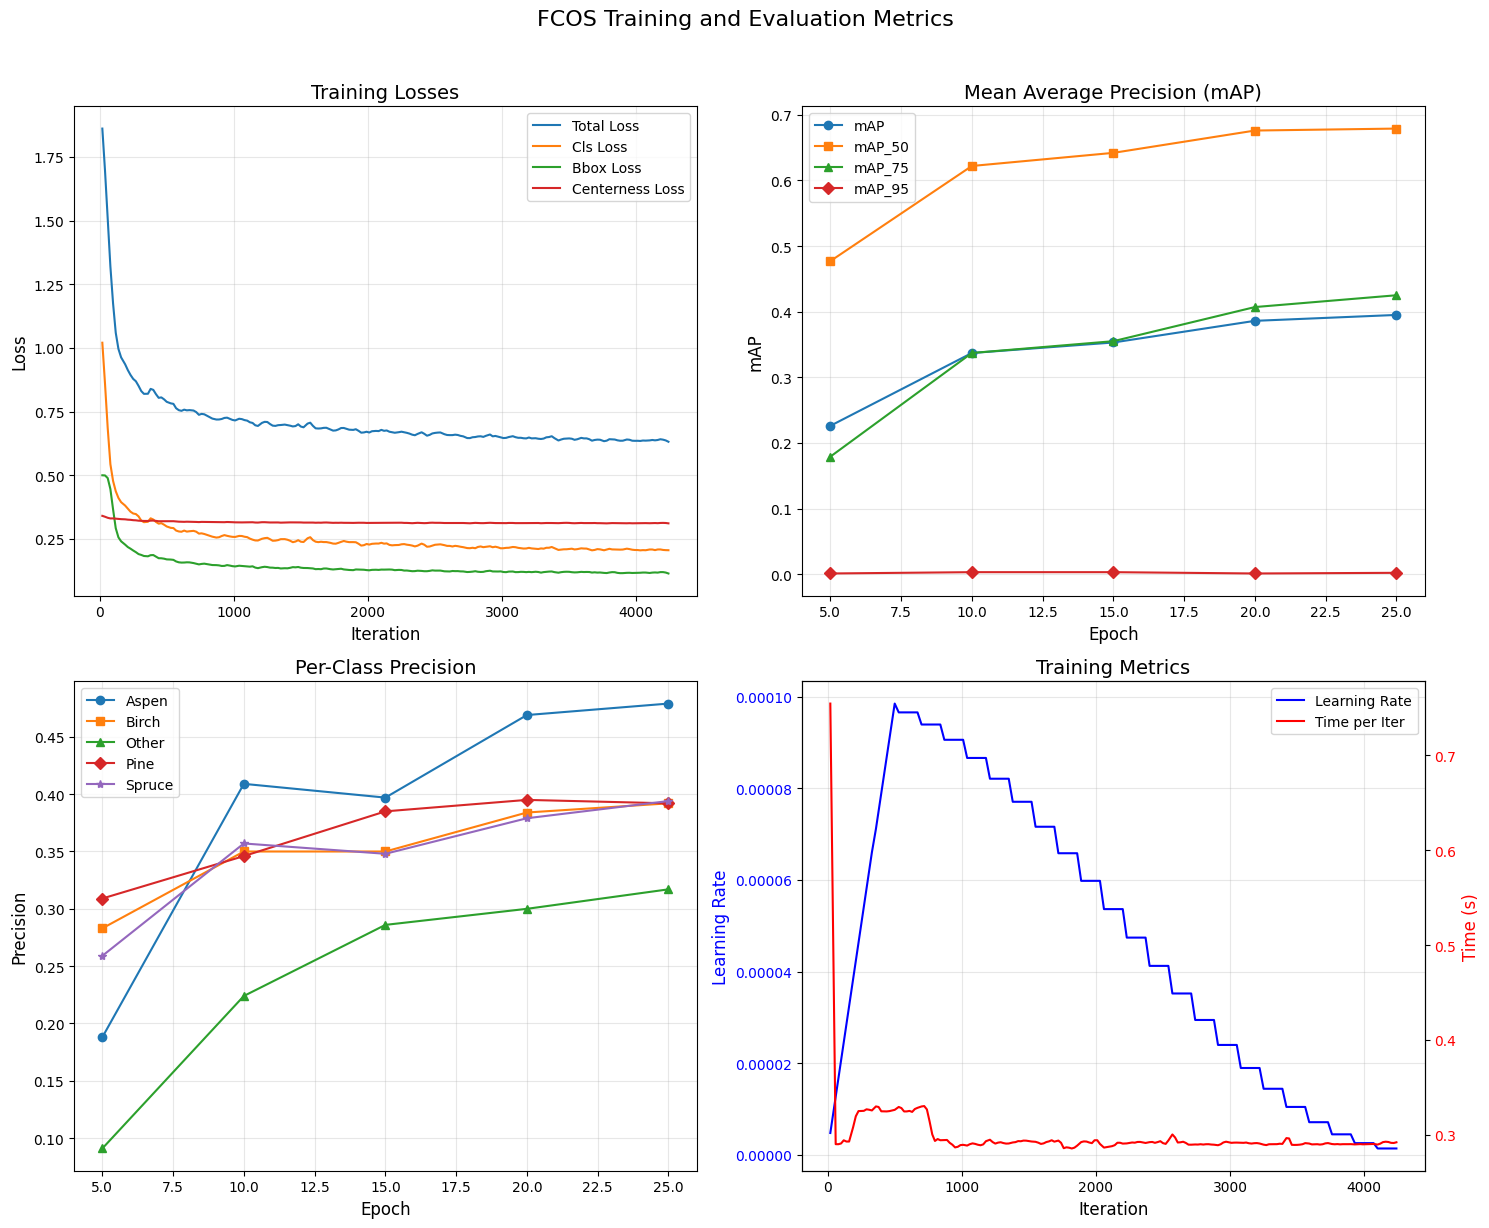

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取数据
training_data = []
performance_data = []

with open('work_dirs\\fcos_forestdamage\\20241230_113651\\vis_data\\20241230_113651.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'coco/bbox_mAP' in data:
            # 性能指标数据
            performance_data.append({
                'step': data['step'],
                'mAP': data['coco/bbox_mAP'],
                'mAP_50': data['coco/bbox_mAP_50'],
                'mAP_75': data['coco/bbox_mAP_75'],
                'mAP_95': data['coco/bbox_mAP_95'],
                'mAP_s': data['coco/bbox_mAP_s'],
                'mAP_m': data['coco/bbox_mAP_m'],
                'mAP_l': data['coco/bbox_mAP_l'],
                'Aspen': data['coco/Aspen_precision'],
                'Birch': data['coco/Birch_precision'],
                'Other': data['coco/Other_precision'],
                'Pine': data['coco/Pine_precision'],
                'Spruce': data['coco/Spruce_precision']
            })
        else:
            # FCOS训练过程数据
            training_data.append({
                'epoch': data['epoch'],
                'iter': data['iter'],
                'lr': data['lr'],
                'loss': data['loss'],
                'loss_cls': data['loss_cls'],
                'loss_bbox': data['loss_bbox'],
                'loss_centerness': data['loss_centerness'],  # FCOS特有的centerness损失
                'time': data['time'],
                'data_time': data['data_time'],
                'memory': data['memory']
            })

# 转换为DataFrame
df_train = pd.DataFrame(training_data)
df_perf = pd.DataFrame(performance_data)

# 创建图表
plt.style.use('default')
fig = plt.figure(figsize=(15, 12))

# 1. 损失曲线
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df_train['iter'], df_train['loss'], label='Total Loss')
ax1.plot(df_train['iter'], df_train['loss_cls'], label='Cls Loss')
ax1.plot(df_train['iter'], df_train['loss_bbox'], label='Bbox Loss')
ax1.plot(df_train['iter'], df_train['loss_centerness'], label='Centerness Loss')  # FCOS特有
ax1.set_title('Training Losses', fontsize=14)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. mAP曲线
ax2 = plt.subplot(2, 2, 2)
ax2.plot(df_perf['step'], df_perf['mAP'], marker='o', label='mAP')
ax2.plot(df_perf['step'], df_perf['mAP_50'], marker='s', label='mAP_50')
ax2.plot(df_perf['step'], df_perf['mAP_75'], marker='^', label='mAP_75')
ax2.plot(df_perf['step'], df_perf['mAP_95'], marker='D', label='mAP_95')
ax2.set_title('Mean Average Precision (mAP)', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('mAP', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. 类别性能
ax3 = plt.subplot(2, 2, 3)
ax3.plot(df_perf['step'], df_perf['Aspen'], marker='o', label='Aspen')
ax3.plot(df_perf['step'], df_perf['Birch'], marker='s', label='Birch')
ax3.plot(df_perf['step'], df_perf['Other'], marker='^', label='Other')
ax3.plot(df_perf['step'], df_perf['Pine'], marker='D', label='Pine')
ax3.plot(df_perf['step'], df_perf['Spruce'], marker='*', label='Spruce')
ax3.set_title('Per-Class Precision', fontsize=14)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. 学习率和时间
ax4 = plt.subplot(2, 2, 4)
ax4_twin = ax4.twinx()

# 左Y轴：学习率
line1 = ax4.plot(df_train['iter'], df_train['lr'], 'b-', label='Learning Rate')
ax4.set_ylabel('Learning Rate', color='b', fontsize=12)
ax4.tick_params(axis='y', labelcolor='b')

# 右Y轴：训练时间
line2 = ax4_twin.plot(df_train['iter'], df_train['time'], 'r-', label='Time per Iter')
ax4_twin.set_ylabel('Time (s)', color='r', fontsize=12)
ax4_twin.tick_params(axis='y', labelcolor='r')

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right', fontsize=10)

ax4.set_title('Training Metrics', fontsize=14)
ax4.set_xlabel('Iteration', fontsize=12)
ax4.grid(True, alpha=0.3)

# 添加总标题
plt.suptitle('FCOS Training and Evaluation Metrics', fontsize=16, y=1.02)

# 调整布局
plt.tight_layout()
plt.show()

<!-- ### 绘制损失 -->

In [4]:
# !python tools/analysis_tools/analyze_logs.py plot_curve work_dirs\\faster_rcnn_foresdamage\\20241227_232520\\vis_data\\20241227_232520.json --keys loss loss_cls loss_bbox loss_rpn_cls loss_rpn_bbox --legend total_loss classification_loss bbox_loss rpn_classification_loss rpn_bbox_loss --out losses.pdf

In [5]:
import os
os.environ['PYTHONIOENCODING'] = 'utf-8'
os.environ['PYTHONUNBUFFERED'] = '1'  # 设置Python不缓存输出




In [1]:
!python tools/test.py \
work_dirs\yolov3_forestdamage\yolov3_forestdamage.py \
work_dirs\yolov3_forestdamage\epoch_80.pth 
# --work-dir work_dirs/test_results \
# --show-dir vis_results 
    # --out results.pkl

12/30 17:53:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 886869552
    GPU 0: NVIDIA GeForce RTX 4090 D
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: 用于 x64 的 Microsoft (R) C/C++ 优化编译器 19.29.30157 版
    GCC: n/a
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: 

In [2]:
!python tools/test.py \
work_dirs\fcos_forestdamage\config.py \
work_dirs\fcos_forestdamage\epoch_25.pth

    # --out results.pkl

12/30 19:33:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 622525174
    GPU 0: NVIDIA GeForce RTX 4090 D
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: 用于 x64 的 Microsoft (R) C/C++ 优化编译器 19.29.30157 版
    GCC: n/a
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: 

d:\miniconda3\envs\sual\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
!python tools/test.py \
work_dirs\faster_rcnn_foresdamage\faster-rcnn_foresdamage.py \
work_dirs\faster_rcnn_foresdamage\best_coco_Aspen_precision_epoch_45.pth

    # --out results.pkl

12/30 19:38:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 745660623
    GPU 0: NVIDIA GeForce RTX 4090 D
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: 用于 x64 的 Microsoft (R) C/C++ 优化编译器 19.29.30157 版
    GCC: n/a
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: 

In [4]:
!python tools/test.py \
work_dirs\deformable-detr_forestdamage\deformable-detr_forestdamage.py \
work_dirs\deformable-detr_forestdamage\epoch_31.pth

12/30 19:43:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 108120977
    GPU 0: NVIDIA GeForce RTX 4090 D
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: 用于 x64 的 Microsoft (R) C/C++ 优化编译器 19.29.30157 版
    GCC: n/a
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: 

d:\miniconda3\envs\sual\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
python tools/train.py my_configs/yolov3_forestdamage.py --work-dir ./work_dirs/yolov3_forestdamage

In [7]:
# 使用不确定性度量模块
!python -m sual.inference.detector \
    work_dirs\faster_rcnn_foresdamage\faster-rcnn_foresdamage.py \
    work_dirs\faster_rcnn_foresdamage\epoch_50.pth \
    raw \
    --device cuda:0 \
    --batch-size 1 \
    --num-workers 2 \
    --use-fp16 \
    --output-dir forest_damage \
    --score-thr 0.5 \
    --nms-thr 0.45 \
    --max-det 100 \
    --uncertainty-methods all \
    --vis-scale 1.0

Loads checkpoint by local backend from path: work_dirs\faster_rcnn_foresdamage\epoch_50.pth
enable_uncertainty value: True

推理完成! 共处理 20 张图片
结果保存在: forest_damage/20241230_201340



Processing images: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]
